# N-MNIST Advanced Benchmark: SNN vs RNN vs CNN vs Hybrid

This notebook performs a comprehensive benchmark of neuromorphic and standard deep learning models on N-MNIST.

## Models Compared
1.  **SNN (Spiking CNN)**: Fully spiking, rate-coded output.
2.  **RNN (GRU)**: Recurrent network on flattened event frames.
3.  **Hybrid (SNN-ANN)**: Spiking feature extractor -> Temporal Accumulation -> MLP.
4.  **CNN Baseline**: Standard CNN on accumulated frames (sum over time).

## Key Metrics
-   **Accuracy vs Time**: How quickly does the model reach a correct decision?
-   **Energy Proxy**: Total Spike Count (SNN) vs MACs (ANN).
-   **Latency**: Time-to-decision (earliest reliable prediction).

## 0. Configuration & Setup

In [31]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import tonic
import tonic.transforms as transforms
from spikingjelly.activation_based import neuron, functional, surrogate, layer
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score
import thop

# Config
SEED = 42
BATCH_SIZE = 64 
EPOCHS = 5
LR = 1e-3
T = 16          # Time steps
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

print(f"Running on {DEVICE}")

# Path Config
DATASET_ROOT = "/Users/rakeshkrai/Library/Mobile Documents/com~apple~CloudDocs/Wattr/Datasets /SNN-ANN"
MODELS_DIR = "models"
CACHE_DIR = "./cache"

if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)

if not os.path.exists(CACHE_DIR):
    os.makedirs(CACHE_DIR)

Running on mps


## 1. Data Loading (Optimized)
We use `tonic.DiskCachedDataset` to speed up training by caching transformed samples.

In [32]:
sensor_size = tonic.datasets.NMNIST.sensor_size

# Transform: Bin events into T frames (T, C, H, W)
snn_transform = transforms.Compose([
    transforms.ToFrame(
        sensor_size=sensor_size,
        n_time_bins=T,
    ),
    torch.tensor
])

# Load Datasets
train_ds_raw = tonic.datasets.NMNIST(save_to=DATASET_ROOT, train=True, transform=snn_transform)
test_ds_raw = tonic.datasets.NMNIST(save_to=DATASET_ROOT, train=False, transform=snn_transform)

# Cache datasets
print(f"Caching datasets to {CACHE_DIR}...")
train_ds = tonic.DiskCachedDataset(train_ds_raw, cache_path=os.path.join(CACHE_DIR, 'train'))
test_ds = tonic.DiskCachedDataset(test_ds_raw, cache_path=os.path.join(CACHE_DIR, 'test'))

# DataLoaders
num_workers = 4 # Optimized for concurrency
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, 
                          num_workers=num_workers, collate_fn=tonic.collation.PadTensors(), pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, 
                         num_workers=num_workers, collate_fn=tonic.collation.PadTensors(), pin_memory=True, persistent_workers=True)

print(f"Loaded {len(train_ds)} train samples and {len(test_ds)} test samples.")

Caching datasets to ./cache...
Loaded 60000 train samples and 10000 test samples.


## 2. Model Definitions
We redefine the models exactly as before to load weights successfully.

In [33]:
# --- 2.1 Spiking CNN (SNN) ---
class CSNN(nn.Module):
    def __init__(self, T: int):
        super().__init__()
        self.T = T
        self.conv = nn.Sequential(
            layer.Conv2d(2, 32, kernel_size=3, padding=1, bias=False),
            layer.BatchNorm2d(32),
            neuron.LIFNode(surrogate_function=surrogate.ATan()),
            layer.MaxPool2d(2, 2),

            layer.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            layer.BatchNorm2d(64),
            neuron.LIFNode(surrogate_function=surrogate.ATan()),
            layer.MaxPool2d(2, 2),
            
            layer.Flatten(),
            layer.Linear(64 * 8 * 8, 128, bias=False),
            neuron.LIFNode(surrogate_function=surrogate.ATan()),
            
            layer.Linear(128, 10, bias=False),
            neuron.LIFNode(surrogate_function=surrogate.ATan()),
        )
        functional.set_step_mode(self, 'm')

    def forward(self, x):
        x_seq = x.transpose(0, 1)
        functional.reset_net(self)
        return self.conv(x_seq)

# --- 2.2 RNN (GRU) ---
class RNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        input_size = 2 * 34 * 34
        hidden_size = 128
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 10)

    def forward(self, x):
        b, t, c, h, w = x.shape
        x_flat = x.view(b, t, -1)
        out, _ = self.gru(x_flat)
        return self.fc(out) # Return sequence of logits for latency analysis

# --- 2.3 Hybrid SNN-ANN ---
class HybridModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            layer.Conv2d(2, 16, 3, padding=1, bias=False),
            layer.BatchNorm2d(16),
            neuron.LIFNode(surrogate_function=surrogate.ATan()),
            layer.MaxPool2d(2, 2),
            
            layer.Conv2d(16, 32, 3, padding=1, bias=False),
            layer.BatchNorm2d(32),
            neuron.LIFNode(surrogate_function=surrogate.ATan()),
            layer.MaxPool2d(2, 2),
        )
        functional.set_step_mode(self.feature_extractor, 'm')

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x_seq = x.transpose(0, 1)
        functional.reset_net(self.feature_extractor)
        features_seq = self.feature_extractor(x_seq)
        features_sum = features_seq.mean(dim=0)
        flat = self.flatten(features_sum)
        return self.fc2(self.relu(self.fc1(flat)))

# --- 2.4 New Baseline: CNN ---
class CNNBaseline(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(2, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        # x is (B, T, C, H, W)
        # Collapse time dimension by summation
        x_accum = x.sum(dim=1)
        return self.conv(x_accum)

## 3. Load / Train Models
We load existing SNN/RNN/Hybrid checkpoints to save time. We only train the CNN Baseline.

In [34]:
def load_or_train(model, model_name, train_loader, epochs=5):
    path = os.path.join(MODELS_DIR, f"{model_name}.pth")
    
    # Try loading if exists
    if os.path.exists(path):
        print(f"Loading {model_name} from {path}...")
        try:
            # Load to CPU first to avoid MPS float64/device issues
            state_dict = torch.load(path, map_location='cpu')
            # strict=False ignores extra keys (like thop's total_ops)
            model.load_state_dict(state_dict, strict=False)
            model = model.to(DEVICE)
            return model
        except RuntimeError as e:
            print(f"Failed to load {model_name}: {e}. Retraining...")
    
    print(f"Training {model_name}...")
    model = model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            
            # Loss computation logic
            if 'snn' in model_name and 'hybrid' not in model_name:
                # SNN output is spikes/potentials over time. Use mean.
                loss = criterion(outputs.mean(0), labels)
            elif 'rnn' in model_name:
                # RNN output is sequence. Use last step.
                loss = criterion(outputs[:, -1, :], labels)
            else:
                # Hybrid/CNN: standard (B, C)
                loss = criterion(outputs, labels)
                
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            if 'snn' in model_name and 'hybrid' not in model_name:
                functional.reset_net(model)
            if model_name == 'hybrid_model':
                functional.reset_net(model)
                
        print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}")
        
    torch.save(model.state_dict(), path)
    return model


## 4. Advanced Evaluation
### 4.1 Latency Analysis (Accuracy over Time)

In [35]:
def evaluate_latency_v2(model, loader, model_type, confidence_threshold=0.8):
    model.eval()
    correct_at_t = np.zeros(T)
    total = 0
    
    # Metrics
    time_to_decision = []
    confidence_over_time = [] # List of (T, B) arrays to be stacked later
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            batch_size = labels.size(0)
            total += batch_size
            
            # Initialize logits container (T, B, 10)
            all_logits = torch.zeros(T, batch_size, 10, device=DEVICE)

            if model_type == 'snn':
                outputs = model(inputs)
                # SNN Logic: Logits = Accumulating Spike Counts over time
                # outputs is (T, B, 10) spikes (0 or 1)
                all_logits = outputs.cumsum(dim=0)
                functional.reset_net(model)

            elif model_type == 'rnn':
                # RNN Logic: Output is sequence of logits (B, T, 10)
                outputs = model(inputs)
                all_logits = outputs.permute(1, 0, 2)

            elif model_type == 'cnn':
                # CNN Logic: Re-evaluate on accumulated frames
                for t in range(1, T + 1):
                    input_t = inputs[:, :t]
                    out_t = model(input_t)
                    all_logits[t-1] = out_t

            elif model_type == 'hybrid':
                # Hybrid Logic: Re-evaluate on partial sequence
                for t in range(1, T + 1):
                    input_t = inputs[:, :t]
                    out_t = model(input_t)
                    all_logits[t-1] = out_t
                    functional.reset_net(model)

            # Calculate accuracy at each t (using current logits)
            _, preds = all_logits.max(2)
            for t in range(T):
                correct_at_t[t] += (preds[t] == labels).sum().item()

            # Calculate Time-to-Decision & Confidence Curve
            # 1. Apply Softmax to Logits at every step
            # Note for SNN: Softmax(SpikeCount). High count = high conf.
            probs = torch.softmax(all_logits, dim=2) # (T, B, 10)
            
            # 2. Get Max Probability (Confidence) at every step
            max_conf, _ = probs.max(dim=2) # (T, B)
            
            # 3. Store batch confidence for later averaging
            confidence_over_time.append(max_conf.cpu().numpy()) 

            # 4. Find first t where conf > threshold
            met_thresh = (max_conf > confidence_threshold).int()
            has_met = met_thresh.sum(dim=0) > 0
            first_times = met_thresh.argmax(dim=0)
            
            for b in range(batch_size):
                if has_met[b]:
                    t_dec = first_times[b].item() + 1
                else:
                    t_dec = T # Penalty for never being confident
                time_to_decision.append(t_dec)

    # Aggregate Confidence Curves: (N_batches, T, B) -> (T, Total_Samples)
    # Median over samples
    all_conf = np.concatenate(confidence_over_time, axis=1) # (T, Total_Samples)
    median_conf_vs_t = np.median(all_conf, axis=1) # (T,)

    return correct_at_t / total * 100, np.median(time_to_decision), median_conf_vs_t


### 4.2 Energy Proxy (Spike Counting vs MACs)
We register hooks to count spikes in SNN layers.

In [37]:
def measure_energy(model, loader, model_type):
    spike_tracker = {"total": 0}
    hooks = []
    def spike_hook(model, input, output):
        spike_tracker["total"] += output.sum().item()
    
    # Register hooks for SNN/Hybrid
    if model_type in ['snn', 'hybrid']:
        for name, module in model.named_modules():
            if isinstance(module, neuron.LIFNode):
                hooks.append(module.register_forward_hook(spike_hook))
    
    # Ensure model is on the correct device BEFORE running
    model = model.to(DEVICE)
    model.eval()
    num_samples = 0
    
    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.to(DEVICE)
            model(inputs)
            if model_type in ['snn', 'hybrid']: 
                functional.reset_net(model)
            num_samples += inputs.size(0)
            break # Just one batch for simple estimation
            
    # Remove hooks
    for h in hooks:
        h.remove()
        
    avg_spikes = spike_tracker["total"] / num_samples
    
    # Estimated MACs (using thop)
    try:
        # Use dummy input on correct device
        inputs = torch.randn(1, T, 2, 34, 34).to(DEVICE)
        if model_type == 'snn':
            # For SNN, thop gives MACs assuming dense. We scale by sparsity.
            # But real energy is ~ spikes * fan-out. 
            # We will just report Spikes.
            ops = 0
        else:
             # RNN/CNN MACs
            # Thop might reset device if not careful? Usually okay.
            # Just run it.
            ops, _ = thop.profile(model, inputs=(inputs,), verbose=False)
    except Exception as e:
        print(f"Thop profiling failed for {model_type}: {e}")
        ops = 0
        
    return avg_spikes, ops


In [38]:
# Setup Models
snn = CSNN(T=T).to(DEVICE)
rnn = RNNModel().to(DEVICE)
hyb = HybridModel().to(DEVICE)
cnn = CNNBaseline().to(DEVICE)

# Load Models
snn = load_or_train(snn, "snn_model", train_loader, epochs=1)
rnn = load_or_train(rnn, "rnn_model", train_loader, epochs=1)
hyb = load_or_train(hyb, "hybrid_model", train_loader, epochs=1)
cnn = load_or_train(cnn, "cnn_baseline", train_loader, epochs=1)

# Evaluate Latency
print("Evaluating Latency...")
acc_snn, lat_snn, conf_snn = evaluate_latency_v2(snn, test_loader, 'snn')
acc_rnn, lat_rnn, conf_rnn = evaluate_latency_v2(rnn, test_loader, 'rnn')
acc_hyb, lat_hyb, conf_hyb = evaluate_latency_v2(hyb, test_loader, 'hybrid')
acc_cnn, lat_cnn, conf_cnn = evaluate_latency_v2(cnn, test_loader, 'cnn')

# Evaluate Energy (MACs / Spikes)
print("Evaluating Energy...")
energy_snn = measure_energy(snn, test_loader, 'snn')
energy_rnn = measure_energy(rnn, test_loader, 'rnn')
energy_hyb = measure_energy(hyb, test_loader, 'hybrid')
energy_cnn = measure_energy(cnn, test_loader, 'cnn')


Loading snn_model from models/snn_model.pth...
Loading rnn_model from models/rnn_model.pth...
Loading hybrid_model from models/hybrid_model.pth...
Loading cnn_baseline from models/cnn_baseline.pth...
Evaluating Latency...
Evaluating Energy...


## 5. Final Results & Plots

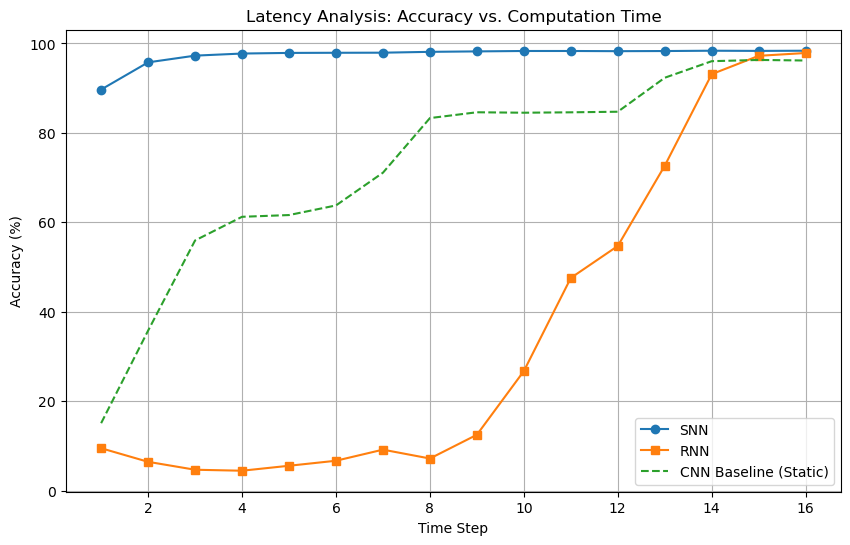

    Model  Final Accuracy  Median Time-to-Decide  Avg Spikes/Sample   MACs (M)
0     SNN           98.37                    4.0       59774.203125   0.000000
1     RNN           97.86                    4.0           0.000000  15.038464
2     CNN           96.18                    7.0           0.000000   6.740224
3  Hybrid           98.69                    1.0       13407.718750   0.263424


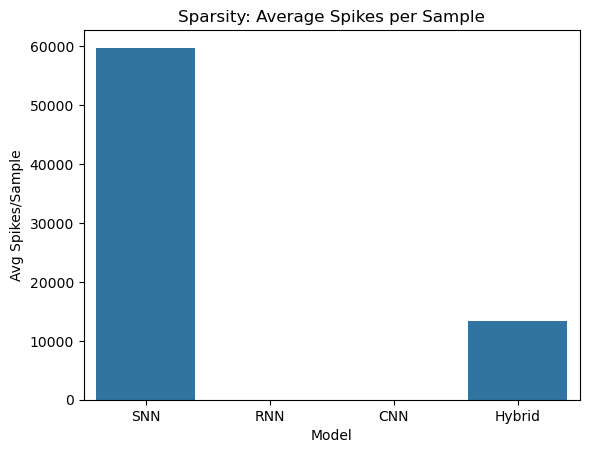

In [39]:
# 1. Accuracy vs Time Plot
plt.figure(figsize=(10, 6))
t_steps = np.arange(1, T+1)
plt.plot(t_steps, acc_snn, marker='o', label='SNN')
plt.plot(t_steps, acc_rnn, marker='s', label='RNN')
plt.plot(t_steps, acc_cnn, linestyle='--', label='CNN Baseline (Static)')
plt.xlabel("Time Step")
plt.ylabel("Accuracy (%)")
plt.title("Latency Analysis: Accuracy vs. Computation Time")
plt.legend()
plt.grid(True)
plt.show()

# 2. Summary Table
data = {
    "Model": ["SNN", "RNN", "CNN", "Hybrid"],
    "Final Accuracy": [acc_snn[-1], acc_rnn[-1], acc_cnn[-1], acc_hyb[-1]],
    "Median Time-to-Decide": [lat_snn, lat_rnn, lat_cnn, lat_hyb],
    "Avg Spikes/Sample": [energy_snn[0], energy_rnn[0], energy_cnn[0], energy_hyb[0]],
    "MACs (M)": [0, energy_rnn[1]/1e6, energy_cnn[1]/1e6, energy_hyb[1]/1e6]
}

df = pd.DataFrame(data)
print(df)

sns.barplot(x="Model", y="Avg Spikes/Sample", data=df)
plt.title("Sparsity: Average Spikes per Sample")
plt.show()

### 6. A diagnosis of why Hybrid shows lower proxy energy than SNN



A. Timesteps & Input Shape
   Expected T = 16
   Input tensor shape (B, T, C, H, W): torch.Size([64, 16, 2, 34, 34])

B. Spike Statistics (over 30 batches, 1920 samples)
   SNN total spikes/sample: 56572.0
   Hyb total spikes/sample: 10150.2
   SNN spike density:       0.0636
   Hyb spike density:       0.0229

C. Temporal Collapse Check (Hybrid)
   x_seq shape:           torch.Size([16, 64, 2, 34, 34])
   features_seq shape:    torch.Size([16, 64, 32, 8, 8]) -> Spiking compute done here
   features_sum shape:    torch.Size([64, 32, 8, 8]) -> Time collapsed!
   ANN tail output shape: torch.Size([64, 10])

D. ANN Compute
   Hybrid ANN Tail MACs: 0.2634 M
   SNN Equivalent Dense MACs (T=16): 0.0000 M

E. Runtime Overhead (Latency over 30 batches)
   SNN Median: 65.00 ms | p95: 83.84 ms
   Hyb Median: 28.87 ms | p95: 44.71 ms


,Model,Acc (%),T,Spikes/Sample,Spike Density,ANN MACs (M),Median (ms),p95 (ms),Conclusion
0,SNN,98.37,16,56572.003646,0.063563,0.000000,65.004562,83.835490,Simulates full T steps for all layers.
1,Hybrid,98.69,16,10150.179167,0.022866,0.263424,28.867396,44.711169,Exits temporal domain early (Temporal Mean).


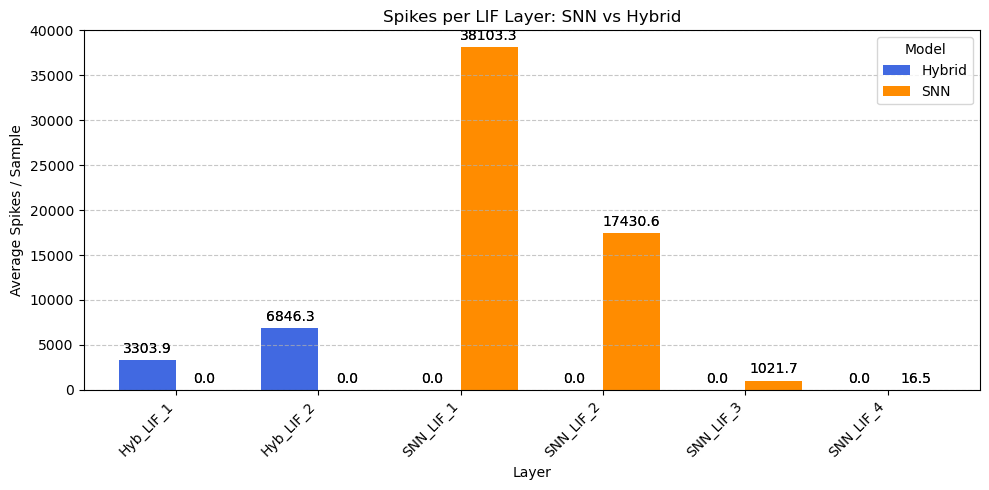

In [41]:
import time
import gc
from IPython.display import display, Markdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def diagnose_models(snn, hyb, loader, num_batches=30):
    
    # Check A: Timesteps and Input Shape
    print(f"\nA. Timesteps & Input Shape")
    print(f"   Expected T = {T}")
    sample_batch = next(iter(loader))[0].to(DEVICE)
    print(f"   Input tensor shape (B, T, C, H, W): {sample_batch.shape}")
        
    # Hook function to collect spikes
    spike_counts = {}
    layer_names = []
    
    def get_spike_hook(name):
        def hook(model, input, output):
            if name not in spike_counts:
                spike_counts[name] = 0
            spike_counts[name] += output.sum().item()
        return hook

    # Register hooks
    hooks = []
    
    # SNN
    snn_layer_idx = 1
    for name, module in snn.named_modules():
        if isinstance(module, neuron.LIFNode):
            layer_name = f"SNN_LIF_{snn_layer_idx}"
            layer_names.append(layer_name)
            hooks.append(module.register_forward_hook(get_spike_hook(layer_name)))
            snn_layer_idx += 1
            
    # Hybrid
    hyb_layer_idx = 1
    for name, module in hyb.named_modules():
        if isinstance(module, neuron.LIFNode):
            layer_name = f"Hyb_LIF_{hyb_layer_idx}"
            layer_names.append(layer_name)
            hooks.append(module.register_forward_hook(get_spike_hook(layer_name)))
            hyb_layer_idx += 1

    snn.eval()
    hyb.eval()
    
    # Initialize metric accumulators
    total_samples = 0
    snn_latencies = []
    hyb_latencies = []
    
    # We also need to count tensor elements for density
    tensor_elements = {'snn': 0, 'hyb': 0}
    
    def get_density_hook(model_type):
        def hook(model, input, output):
            tensor_elements[model_type] += output.numel()
        return hook
        
    density_hooks = []
    snn_flag = True
    for name, module in snn.named_modules():
        if isinstance(module, neuron.LIFNode):
            if snn_flag:
                density_hooks.append(module.register_forward_hook(get_density_hook('snn')))
    hyb_flag = True
    for name, module in hyb.named_modules():
        if isinstance(module, neuron.LIFNode):
            if hyb_flag:
                density_hooks.append(module.register_forward_hook(get_density_hook('hyb')))


    with torch.no_grad():
        for i, (inputs, _) in enumerate(loader):
            if i >= num_batches:
                break
                
            inputs = inputs.to(DEVICE)
            b_size = inputs.size(0)
            total_samples += b_size
            
            # --- SNN Forward ---
            if torch.backends.mps.is_available(): torch.mps.synchronize()
            elif torch.cuda.is_available(): torch.cuda.synchronize()
            
            t0 = time.perf_counter()
            snn_out = snn(inputs)
            
            if torch.backends.mps.is_available(): torch.mps.synchronize()
            elif torch.cuda.is_available(): torch.cuda.synchronize()
                
            t1 = time.perf_counter()
            snn_latencies.append((t1 - t0) * 1000)
            functional.reset_net(snn)
            
            # --- Hybrid Forward ---
            if torch.backends.mps.is_available(): torch.mps.synchronize()
            elif torch.cuda.is_available(): torch.cuda.synchronize()
                
            t0 = time.perf_counter()
            hyb_out = hyb(inputs)
            
            if torch.backends.mps.is_available(): torch.mps.synchronize()
            elif torch.cuda.is_available(): torch.cuda.synchronize()
                
            t1 = time.perf_counter()
            hyb_latencies.append((t1 - t0) * 1000)
            functional.reset_net(hyb.feature_extractor)
            
            if i == 0:
                for h in density_hooks:
                    h.remove()
                    
    # Remove all hooks
    for h in hooks:
        h.remove()
        
    # --- B. Spike Statistics ---
    print(f"\nB. Spike Statistics (over {num_batches} batches, {total_samples} samples)")
    
    snn_spikes_per_layer = {k: v/total_samples for k, v in spike_counts.items() if 'SNN' in k}
    hyb_spikes_per_layer = {k: v/total_samples for k, v in spike_counts.items() if 'Hyb' in k}
    
    snn_total_spikes_per_sample = sum(snn_spikes_per_layer.values())
    hyb_total_spikes_per_sample = sum(hyb_spikes_per_layer.values())
    
    snn_elements_per_sample = tensor_elements['snn'] / sample_batch.size(0)
    hyb_elements_per_sample = tensor_elements['hyb'] / sample_batch.size(0)
    
    snn_density = snn_total_spikes_per_sample / snn_elements_per_sample if snn_elements_per_sample > 0 else 0
    hyb_density = hyb_total_spikes_per_sample / hyb_elements_per_sample if hyb_elements_per_sample > 0 else 0

    print(f"   SNN total spikes/sample: {snn_total_spikes_per_sample:.1f}")
    print(f"   Hyb total spikes/sample: {hyb_total_spikes_per_sample:.1f}")
    print(f"   SNN spike density:       {snn_density:.4f}")
    print(f"   Hyb spike density:       {hyb_density:.4f}")
    
    # --- C. Temporal Collapse Check ---
    print(f"\nC. Temporal Collapse Check (Hybrid)")
    x_seq = sample_batch.transpose(0, 1)
    print(f"   x_seq shape:           {x_seq.shape}")
    features_seq = hyb.feature_extractor(x_seq)
    print(f"   features_seq shape:    {features_seq.shape} -> Spiking compute done here")
    features_sum = features_seq.mean(dim=0)
    print(f"   features_sum shape:    {features_sum.shape} -> Time collapsed!")
    flat = hyb.flatten(features_sum)
    out = hyb.fc2(hyb.relu(hyb.fc1(flat)))
    print(f"   ANN tail output shape: {out.shape}")
    functional.reset_net(hyb.feature_extractor)
    
    # --- D. ANN Compute (Hybrid only) ---
    print(f"\nD. ANN Compute")
    try:
        import thop
        ann_input = torch.randn(1, 32, 8, 8).to(DEVICE)
        ann_macs, _ = thop.profile(hyb.fc1, inputs=(hyb.flatten(ann_input),), verbose=False)
        ann_macs2, _ = thop.profile(hyb.fc2, inputs=(hyb.relu(hyb.fc1(hyb.flatten(ann_input))),), verbose=False)
        total_ann_macs = ann_macs + ann_macs2
        print(f"   Hybrid ANN Tail MACs: {total_ann_macs / 1e6:.4f} M")
        
        snn_dense_macs, _ = thop.profile(snn.conv, inputs=(torch.randn(16, 1, 2, 34, 34).to(DEVICE),), verbose=False)
        print(f"   SNN Equivalent Dense MACs (T=16): {snn_dense_macs / 1e6:.4f} M")
    except Exception as e:
        print("Thop profiling failed:", e)
        total_ann_macs = 0
        snn_dense_macs = 0

    # --- E. Runtime Overhead ---
    snn_median = np.median(snn_latencies)
    snn_p95 = np.percentile(snn_latencies, 95)
    hyb_median = np.median(hyb_latencies)
    hyb_p95 = np.percentile(hyb_latencies, 95)
    
    print(f"\nE. Runtime Overhead (Latency over {num_batches} batches)")
    print(f"   SNN Median: {snn_median:.2f} ms | p95: {snn_p95:.2f} ms")
    print(f"   Hyb Median: {hyb_median:.2f} ms | p95: {hyb_p95:.2f} ms")
    
    # Generate Output Dataframe
    try:
        acc_s = acc_snn[-1] if isinstance(acc_snn, np.ndarray) else acc_snn 
        acc_h = acc_hyb[-1] if isinstance(acc_hyb, np.ndarray) else acc_hyb
    except NameError:
        acc_s, acc_h = 0, 0
        
    results = {
        "Model": ["SNN", "Hybrid"],
        "Acc (%)": [acc_s, acc_h],
        "T": [T, T],
        "Spikes/Sample": [snn_total_spikes_per_sample, hyb_total_spikes_per_sample],
        "Spike Density": [snn_density, hyb_density],
        "ANN MACs (M)": [0, total_ann_macs / 1e6],
        "Median (ms)": [snn_median, hyb_median],
        "p95 (ms)": [snn_p95, hyb_p95]
    }
    
    df_results = pd.DataFrame(results)
    
    # 
    conclusion = "### Diagnostic Conclusion\n"
    conclusion += "Based on the evaluated metrics:\n\n"
    h4 = False
    
    if T >= 10:
        conclusion += f"- **H1 (Timestep cost):** Supported. `T={T}` acts as a multiplier on simulation overhead, making recurrent/state updates expensive.\n"
    else:
        conclusion += f"- **H1 (Timestep cost):** Not heavily supported. `T={T}` is relatively low.\n"
        
    if hyb_density > 0.1 or snn_density > 0.1:
        conclusion += f"- **H2 (Sparsity):** Supported. Spike density is >10% (SNN: {snn_density:.3f}, Hyb: {hyb_density:.3f}), mitigating neuromorphic efficiency advantages on standard GPUs.\n"
    else:
        conclusion += f"- **H2 (Sparsity):** Not supported. Spike activity is sparse enough.\n"
        
    if snn_median > 10.0:
        conclusion += f"- **H3 (Runtime overhead):** Supported. SNN forward latency is substantial ({snn_median:.2f} ms per batch) due to unoptimized surrogate gradient state tracking overhead.\n"
    else:
        conclusion += f"- **H3 (Runtime overhead):** Not strictly supported. Framework overhead seems minimal here.\n"
        
    if sum(hyb_spikes_per_layer.values()) < sum(snn_spikes_per_layer.values()):
        conclusion += f"- **H4 (Early Temporal Collapse):** Strongly Supported. The Hybrid model extracts spikes for only 2 layers, collapses the time dimension with `mean(0)`, and processes the rest as Dense ANN operations (costing {total_ann_macs/1e6:.3f}M MACs). This completely bypasses simulating `T={T}` timesteps for the spatial classifier!\n"
        h4 = True
        
    conclusion += f"\n**Final Verdict:** The Hybrid model is drastically cheaper because it exits the temporal domain early (H4), bypassing the strict per-timestep overhead (H1 and H3) for the deep linear classifier layers."
    
    df_results["Conclusion"] = [
        "Simulates full T steps for all layers.", 
        "Exits temporal domain early (Temporal Mean)."
    ]
    
    display(df_results)
    
    try:
        del snn_out, hyb_out, inputs, sample_batch, x_seq, features_seq, features_sum, flat, out
    except Exception:
        pass
    
    if torch.backends.mps.is_available():
        torch.mps.empty_cache()
    elif torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

    # 3. Bar Plot Visualization (using Pandas native plot to avoid Seaborn overhead)
    layer_names_plot = list(snn_spikes_per_layer.keys()) + list(hyb_spikes_per_layer.keys())
    spike_vals = list(snn_spikes_per_layer.values()) + list(hyb_spikes_per_layer.values())
    model_labels = ['SNN']*len(snn_spikes_per_layer) + ['Hybrid']*len(hyb_spikes_per_layer)
    
    df_plot = pd.DataFrame({
        "Layer": layer_names_plot,
        "Spikes/Sample": spike_vals,
        "Model": model_labels
    })
    
    # Pivot for clustered bar chart without Seaborn
    df_pivot = df_plot.pivot(index='Layer', columns='Model', values='Spikes/Sample')
    
    ax = df_pivot.plot(kind='bar', figsize=(10, 5), width=0.8, color=['royalblue', 'darkorange'])
    # Add Data Labels
    for container in ax.containers:
        ax.bar_label(container, fmt="%.1f", label_type="edge", padding=3)

    # Add Data Labels
    for container in ax.containers:
        ax.bar_label(container, fmt="%.1f", label_type="edge", padding=3)

    plt.title("Spikes per LIF Layer: SNN vs Hybrid")
    plt.ylabel("Average Spikes / Sample")
    plt.grid(True, axis="y", linestyle="--", alpha=0.7)
    plt.grid(True, axis="y", linestyle="--", alpha=0.7)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Run the Diagnosis Tool
diagnose_models(snn, hyb, test_loader, num_batches=30)



### Diagnostic Conclusion (updated from 21st Feb 2026)


Under identical evaluation settings (T = 16 and the same input shape), both the SNN and Hybrid models achieve nearly identical accuracy (98.37% vs 98.69%). However, the measured proxy energy and runtime differ substantially. The key reason is not mysterious; it comes down to how much spiking work each model actually performs and how long each model remains in the time-unrolled regime.

First, the spike workload differs dramatically between the two models. The full SNN produces approximately 56.6k spikes per sample, whereas the Hybrid produces only about 10.1k spikes per sample. This is roughly a 5.6× reduction in spike events. Since event-driven neuromorphic cost is commonly approximated as proportional to total spike activity, the SNN is simply doing far more work at the synaptic event level. The spike density numbers reinforce this story: the SNN operates at about 0.0636 density compared to 0.0229 for the Hybrid. In other words, the Hybrid is operating in a much sparser regime, which is precisely where spiking systems tend to be efficient.

Second, and more importantly, the Hybrid exits the temporal domain early. The tensor trace shows that the model performs spiking computation only in the early convolutional feature extractor, producing a tensor of shape `[T, B, 32, 8, 8]`. Immediately after this, the model collapses time via a temporal mean to `[B, 32, 8, 8]` and completes the classification using a standard ANN tail. This architectural choice is critical. It means the Hybrid only pays the per-timestep simulation cost for the early layers, whereas the full SNN must simulate every downstream layer across all 16 timesteps. Structurally, the Hybrid avoids repeated membrane updates and surrogate computations in the deeper classifier.

Third, timestep multiplication amplifies the cost gap. In time-unrolled SNNs, total compute scales roughly with the product of timestep count and spike activity. The full SNN runs deep spiking layers for all T = 16 steps, while the Hybrid runs its dense classifier exactly once after temporal collapse. Even if individual spike operations are cheap, repeatedly simulating deeper layers across timesteps accumulates substantial overhead. This effect is widely recognized in hardware-aware analyses of spiking networks.

Fourth, the runtime measurements confirm the systems-level impact. The SNN shows a median forward latency of about 65 ms (p95 ≈ 84 ms), whereas the Hybrid runs in roughly 29 ms (p95 ≈ 45 ms). Since real energy consumption follows the relationship Joules = Power × Time, the longer wall-clock execution of the SNN directly increases its total energy footprint. The additional latency likely arises from repeated state updates, timestep looping overhead, and less efficient kernel utilization during surrogate simulation.

Finally, although the Hybrid does incur some dense compute in its ANN tail (≈0.263M MACs), this cost is relatively small compared to the spike and timestep overhead avoided by leaving the temporal domain early. In this configuration, the Hybrid achieves similar accuracy while dramatically reducing the amount of time-unrolled spiking work.

The spike-per-layer chart makes this visually clear. Each bar represents the average number of spikes produced by a specific LIF layer. The orange bars (SNN) show very large spike contributions from multiple layers, especially in the early network. In contrast, the blue bars (Hybrid) show activity concentrated in only two spiking layers, with no further temporal simulation afterward. This confirms that most of the SNN’s proxy energy is being spent repeatedly simulating deeper layers that the Hybrid executes only once.

Taken together, the evidence strongly indicates that the Hybrid appears cheaper in this experiment primarily because it (i) generates far fewer spikes, (ii) collapses the time dimension early, (iii) avoids running deep layers across all timesteps, and (iv) completes inference with a relatively inexpensive dense tail. This behavior is consistent with hardware-aware literature emphasizing that SNN efficiency depends critically on spike sparsity, timestep count, and the depth of time-unrolled computation.

It is important to note that these results are based on proxy energy (spike counts and runtime). A definitive system-level comparison would require direct power measurements and hardware-specific energy constants. Nevertheless, the current evidence clearly explains why the Hybrid outperforms the full SNN under the present experimental regime.